In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

In [2]:
# read csv and establish dataframe variable
happiness_df = pd.read_csv("Happiness_Cities_Weather_2018_Clean.csv")
happiness_df.head()

,Unnamed: 0,Overall Rank (1=Best),City,State,Total Score,Lat,Lng,DateUTC,Summary,Icon,Sunrise Time,Sunset Time,Cloud Cover,UV Index
0,0,168,Akron,OH,44.05,41.081445,-81.519005,1514786400,Foggy throughout the day.,fog,1514811149,1514844561,0.66,1
1,1,168,Akron,OH,44.05,41.081445,-81.519005,1514872800,Foggy throughout the day.,fog,1514897553,1514931012,0.52,2
2,2,168,Akron,OH,44.05,41.081445,-81.519005,1514959200,Foggy throughout the day.,fog,1514983955,1515017464,0.59,1
3,3,168,Akron,OH,44.05,41.081445,-81.519005,1515045600,Foggy throughout the day.,fog,1515070354,1515103918,0.92,1
4,4,168,Akron,OH,44.05,41.081445,-81.519005,1515132000,Foggy throughout the day.,fog,1515156751,1515190373,0.31,2


In [3]:
# import dependencies
import gmaps
from config1 import (gkey)

# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [4]:
# groupby cloud cover indexed to total score 
clouds = happiness_df[["Cloud Cover", "Total Score"]].groupby("Total Score")

# calculated mean of cloud cover percentages per city
clouds_mean = clouds.mean()
clouds_mean.head()


,Cloud Cover
Total Score,
29.19,0.588384
39.48,0.528658
39.68,0.610521
40.78,0.433562
40.81,0.595288


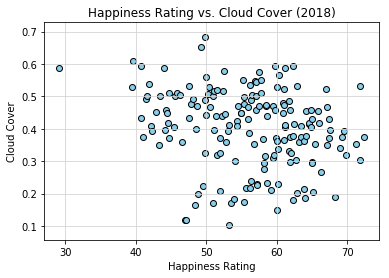

In [5]:
# scatter plot illustrating relationship between happienss score and cloud cover
plt.scatter(clouds_mean.index,clouds_mean["Cloud Cover"],edgecolors="black",facecolors="skyblue")
plt.title("Happiness Rating vs. Cloud Cover (2018)")
plt.xlabel("Happiness Rating")
plt.ylabel("Cloud Cover")
plt.grid(b=True,which="major",axis="both",linestyle="-",color="lightgrey")
plt.savefig("fig1.png")
plt.show()

In [6]:
# data consolidation of lat, lng, and total score
consolidated = happiness_df[["Lat", "Lng", "Total Score"]]
consolidated_dups = consolidated.drop_duplicates(keep = "first") 
consolidated_dups.head()

,Lat,Lng,Total Score
0,41.081445,-81.519005,44.05
365,35.084386,-106.650422,51.15
730,35.221997,-101.831297,56.21
1095,33.836593,-117.914301,65.02
1460,32.735687,-97.108066,61.73


In [7]:
# Set variables for merging dataframes 
combined = pd.merge(consolidated_dups, clouds_mean, how = "left", on = "Total Score")

UV_combined = happiness_df[["UV Index", "Total Score"]].groupby("Total Score")
UV_combined_mean = UV_combined.mean()

combined2 = pd.merge(UV_combined_mean, combined, how = "left", on = "Total Score")

total_happiness = happiness_df[["Cloud Cover", "Total Score"]].groupby("Total Score")
total_happiness_mean = clouds.mean()

# Store 'Lat' and 'Lng' into  locations 
locations = combined[["Lat", "Lng"]].astype(float)

# Convert Total Score to float and store
total_score = combined["Total Score"].astype(float)

# Convert Cloud Cover to float and store
cloud_cover = combined["Cloud Cover"].astype(float)

# Convert Cloud Cover to float and store
uv_index = combined2["UV Index"].astype(float)

In [8]:
# Create a Total Score Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=total_score, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [9]:
# add heat layer with cloud cover
heat_layer_2 = gmaps.heatmap_layer(locations, weights=cloud_cover, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

heat_layer_2.opacity = 1
fig.add_layer(heat_layer_2)

fig

Figure(layout=FigureLayout(height='420px'))

In [10]:
# Show correlation 
combined2.corr()**2

,Total Score,UV Index,Lat,Lng,Cloud Cover
Total Score,1.000000,0.024297,0.000187,0.111865,0.052577
UV Index,0.024297,1.000000,0.671033,0.189847,0.667054
Lat,0.000187,0.671033,1.000000,0.001708,0.166512
Lng,0.111865,0.189847,0.001708,1.000000,0.367977
Cloud Cover,0.052577,0.667054,0.166512,0.367977,1.000000


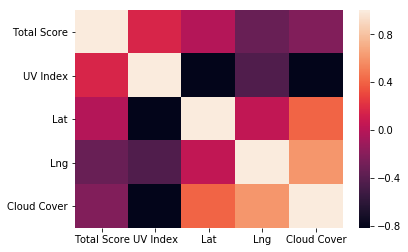

In [11]:
# sns dependecies
import seaborn as sns

# sns heatmap
sns.heatmap(combined2.corr())
plt.savefig("snsheatmapfinal.png")

In [12]:
# show data through describe
combined2.describe()

,Total Score,UV Index,Lat,Lng,Cloud Cover
count,178.000000,178.000000,178.000000,178.000000,178.000000
mean,56.012472,5.763364,36.936230,-95.888933,0.402179
std,8.067023,0.873916,5.121335,16.539472,0.118915
min,29.190000,3.967123,25.761680,-123.035096,0.101342
25%,50.340000,4.981507,33.478666,-112.055790,0.331123
50%,56.925000,5.849315,36.468329,-94.074363,0.413123
75%,61.852500,6.493836,41.042257,-81.547410,0.489185
max,72.300000,7.873278,47.658780,-70.214776,0.684274


In [13]:
# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm # import statsmodels 

# OLS regression results longitude vs. total score
X = combined2[["Lng"]] ## X usually means our input variables (or independent variables)
y = combined2["Total Score"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total Score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     22.17
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           5.04e-06
Time:                        17:17:16   Log-Likelihood:                -613.14
No. Observations:                 178   AIC:                             1230.
Df Residuals:                     176   BIC:                             1237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3700      3.371     11.975      0.000      33.717      47.023
Lng           -0.1631      0.035     -4.708      0.000      -0.232      -0.095
==============================================================================
Omnibus:                        4.161   Durbin-Watson:                   0.233
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.580
Skew:                          -0.257   Prob(JB):                        0.167
Kurtosis:                       2.533   Cond. No.                         574.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# OLS regression results cloud cover vs. total score
X = combined2[["Cloud Cover"]] ## X usually means our input variables (or independent variables)
y = combined2["Total Score"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total Score   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     9.767
Date:                Wed, 09 Oct 2019   Prob (F-statistic):            0.00208
Time:                        17:17:28   Log-Likelihood:                -618.89
No. Observations:                 178   AIC:                             1242.
Df Residuals:                     176   BIC:                             1248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          62.2684      2.087     29.837      0.000      58.150      66.387
Cloud Cover   -15.5552      4.977     -3.125      0.002     -25.378      -5.732
==============================================================================
Omnibus:                        5.079   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                3.930
Skew:                          -0.247   Prob(JB):                        0.140
Kurtosis:                       2.465   Cond. No.                         9.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""